# OPENCLASSROOMS - PARCOURS DATA SCIENTIST

# Projet 7 - *'Implémentez un modèle de scoring'*

In [1]:
#Librairies de manipulation des données
import pandas as pd
import numpy as np

#Librairies de gestion système
import os
os.chdir('..')
import warnings
import gc
import sys
import mlflow

#Visualisation des données
import matplotlib.pyplot as plt
import seaborn as sns
import shap

#Ajout du folder src pour l'import des fonctions de nos différents fichiers
sys.path.append('src')
sys.path.append('input')
warnings.filterwarnings("ignore")
os.chdir('src')

#Importation des fonctions permettant d'importer les résultats, les modèles et les données
from train import pkl_import
from utils import experiments_lister
from utils import run_lister
from utils import cv_results_returner
from utils import run_metrics

# 1- Importation des données à partir de l'expérience

In [7]:
#Affichage de la liste des expériences

os.chdir('..')
exp_dict = experiments_lister()
exp_dict

{'PROJECT_7_OC_DS_EXPERIENCE_REFERENCE': '166951002022495853',
 'DEMO_DATA_SAMPLED': '453417704798808810'}

In [12]:
#Affichage des runs de notre expérience

exp_name = 'PROJECT_7_OC_DS_EXPERIENCE_REFERENCE'
exp_id = exp_dict[exp_name]
os.chdir('..')
run_dict = run_lister(exp_id)
os.chdir('..')
run_dict

{'HistGradBooster_Class_Weight': '24ac298a81f4400c8f804cda23fcd1c8',
 'Log_Reg_SMOTE_Full_v2': '71a400e8463d4cffb924cc71c19b0323',
 'LGBM_Class_Weight_v2': '75ed012842494ec7ba9ca32fc3ac850e',
 'DummyClassifier': '9ec0fff9adf3444db32e0380b1e19d57',
 'Log_Reg_Class_Weight': 'a016e1946504488ba1fba6cd28c2a49d',
 'Log_Reg_Class_Weight_Full': 'e046c700b1814f5e87c650122816ebba',
 'LGBM_Class_Weight': 'ede672b9c1d74e64aace66b26dd39161'}

In [19]:
#Importation des données communes aux runs

random_run_id = run_dict[list(run_dict.keys())[0]]
data_path = 'mlruns/' + exp_id + '/' + random_run_id + '/artifacts/preprocessed'
train = pd.read_pickle(data_path + '/train.pkl')
production = pd.read_pickle(data_path + '/test.pkl')
target = pd.read_pickle(data_path + '/target.pkl')

In [22]:
#Affichage des données d'entraîenemnt

train.sample(3)

,PREV_NAME_GOODS_CATEGORY_Education_MEAN,POS_NAME_CONTRACT_STATUS_Demand_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Buying a home_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Payments on other loans_MEAN,PREV_CHANNEL_TYPE_Car dealer_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Buying a new car_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Furniture_MEAN,REGION_POPULATION_RELATIVE,PREV_NAME_GOODS_CATEGORY_Fitness_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Car repairs_MEAN,...,INSTAL_PAYMENT_DIFF_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,APPROVED_AMT_CREDIT_MIN,INSTAL_PAYMENT_DIFF_SUM,AMT_INCOME_TOTAL,AMT_CREDIT,INSTAL_AMT_PAYMENT_SUM,INSTAL_PAYMENT_PERC_VAR,INSTAL_PAYMENT_DIFF_VAR
186980,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006008,0.0,0.0,...,0.0,103405.545000,-1660.0,103608.0,0.00,166500.0,545040.0,517027.725,0.000000,0.000000
294622,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010147,0.0,0.0,...,3132.0,9333.651316,-22051.0,15345.0,3133.08,337500.0,360000.0,177339.375,0.052593,516265.754021
205565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.032561,0.0,0.0,...,0.0,16446.771000,-1974.0,75753.0,0.00,225000.0,405000.0,82233.855,0.000000,0.000000


In [23]:
#Affichage des données de production

production.sample(3)

,PREV_NAME_GOODS_CATEGORY_Education_MEAN,POS_NAME_CONTRACT_STATUS_Demand_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Buying a home_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Payments on other loans_MEAN,PREV_CHANNEL_TYPE_Car dealer_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Buying a new car_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Furniture_MEAN,REGION_POPULATION_RELATIVE,PREV_NAME_GOODS_CATEGORY_Fitness_MEAN,PREV_NAME_CASH_LOAN_PURPOSE_Car repairs_MEAN,...,INSTAL_PAYMENT_DIFF_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,APPROVED_AMT_CREDIT_MIN,INSTAL_PAYMENT_DIFF_SUM,AMT_INCOME_TOTAL,AMT_CREDIT,INSTAL_AMT_PAYMENT_SUM,INSTAL_PAYMENT_PERC_VAR,INSTAL_PAYMENT_DIFF_VAR
330037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015221,0.0,0.0,...,0.000,25617.375000,-3212.0,96979.5,0.00,90000.0,450000.0,102469.500,0.000000,0.000000
323908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009334,0.0,0.0,...,0.000,15999.630000,-10605.0,85005.0,0.00,360000.0,495000.0,95997.780,0.000000,0.000000
330976,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.018850,0.0,0.0,...,5321.655,47133.479605,-46699.0,20245.5,5335.83,99000.0,124380.0,1791072.225,0.026173,745161.456087


In [24]:
#Affichage des données cibles

target.sample(3)

,TARGET
66038,0.0
44975,1.0
50626,0.0


# 2- Comparaison des performances des modèles

*NB: Cette méthode est la même que celle utilisée dans le fichier app.py, pour afficher les métriques à la page Experiences côté client.*

In [25]:
#Exemple d'utilisation de la fonction run_metrics

run_metrics(exp_id, random_run_id, 'HistGradBooster_Class_Weight')

,Inference_time,Test_ACC,Test_AUC,Test_balanced_ACC,Test_custom_score,Test_F1,Test_REC,Training_time,Train_ACC,Train_AUC,Train_balanced_ACC,Train_custom_score,Train_F1,Train_REC,Val_score
HistGradBooster_Class_Weight,0.0783851146697998,0.7012942668531105,0.6658426503254533,0.6658426503254533,-0.5722090338525576,0.2520864715222082,0.6235649546827795,12.892865180969238,0.712729416068779,0.7179699465828999,0.7179699465829,-0.4876445600699173,0.2892916046502273,0.7242195367573011,-0.5735330582711733


In [26]:
#Concaténation de tous les résultats

metrics_df = pd.DataFrame()

for run in list(run_dict.keys()):
    tmp = run_metrics(exp_dict[exp_name], run_dict[str(run)], str(run))
    metrics_df = pd.concat([metrics_df, tmp])
    
metrics_df

,Inference_time,Test_ACC,Test_AUC,Test_balanced_ACC,Test_custom_score,Test_F1,Test_REC,Training_time,Train_ACC,Train_AUC,Train_balanced_ACC,Train_custom_score,Train_F1,Train_REC,Val_score
HistGradBooster_Class_Weight,0.0783851146697998,0.7012942668531105,0.6658426503254533,0.6658426503254533,-0.5722090338525576,0.2520864715222082,0.6235649546827795,12.892865180969238,0.712729416068779,0.7179699465828999,0.7179699465829,-0.4876445600699173,0.2892916046502273,0.7242195367573011,-0.5735330582711733
Log_Reg_SMOTE_Full_v2,0.015624761581420898,0.8301193457123346,0.5920572186852798,0.5920572186852799,-0.672547234236285,0.2265324252294936,0.3081570996978852,8.88711166381836,0.8308530314424504,0.5969577731511414,0.5969577731511413,-0.66464909249812,0.23287797503825378,0.3180261832829809,-0.6358
LGBM_Class_Weight_v2,0.06251907348632812,0.6809209456603037,0.662477749645755,0.662477749645755,-0.5802900718675815,0.24476600985221675,0.6404833836858006,12.115844964981079,0.6827381557285421,0.6755229346810413,0.6755229346810414,-0.5592691205463304,0.25340067726568327,0.6669184290030211,-0.5733582650759131
DummyClassifier,0.01563096046447754,0.9192709180189262,0.5,0.5,-0.8072908198107379,0.0,0.0,0.01562356948852539,0.9192699335379362,0.5,0.5,-0.8073006646206378,0.0,0.0,NaN
Log_Reg_Class_Weight,0.06292366981506348,0.6798803290949887,0.664851306012277,0.6648513060122772,-0.5766479138889792,0.2460171568627451,0.6469284994964754,12.217413187026978,0.681628422186541,0.6758609154171843,0.6758609154171843,-0.5588788845755167,0.25332481671798884,0.668982880161128,-0.5633828580719904
Log_Reg_Class_Weight_Full,0.04873490333557129,0.67962017495366,0.6648935280928329,0.6648935280928329,-0.5766153946213132,0.24598193785397213,0.6473313192346425,10.977183818817139,0.681445499075222,0.6758532827806986,0.6758532827806987,-0.5589154691977806,0.25327311188611284,0.6691842900302115,-0.5634397674844008
LGBM_Class_Weight,0.0625,0.6807746089558063,0.7208225268835793,0.6626737392570285,-0.5799973984585867,0.24485557136812955,0.6410876132930513,10.947654485702515,0.6828682343854799,0.7364968372763538,0.6752262415430643,-0.5597243958456128,0.253249612343741,0.6661127895266868,-0.5728664051543669


## 2.1- Comparaison des temps d'inférence

In [28]:
#Projection sur la colonne inference_time

inference_df = metrics_df[['Inference_time']]
inference_df

,Inference_time
HistGradBooster_Class_Weight,0.0783851146697998
Log_Reg_SMOTE_Full_v2,0.015624761581420898
LGBM_Class_Weight_v2,0.06251907348632812
DummyClassifier,0.01563096046447754
Log_Reg_Class_Weight,0.06292366981506348
Log_Reg_Class_Weight_Full,0.04873490333557129
LGBM_Class_Weight,0.0625


In [49]:
#Gestion des longueurs de temps affichés

inference_times_str = []
for i in inference_df[['Inference_time']].values[:,0].astype(str):
    inference_times_str.append(i[:5])
inference_times_float = np.array(inference_times_str).astype(float)
inference_times_float

array([0.078, 0.015, 0.062, 0.015, 0.062, 0.048, 0.062])

In [51]:
#Création deuxième dataframe

inference_df_2 = pd.DataFrame({'times' : inference_times_float, 'model' : inference_df.index}).sort_values(by = 'times', ascending = False)
inference_df_2

,times,model
0,0.078,HistGradBooster_Class_Weight
2,0.062,LGBM_Class_Weight_v2
4,0.062,Log_Reg_Class_Weight
6,0.062,LGBM_Class_Weight
5,0.048,Log_Reg_Class_Weight_Full
1,0.015,Log_Reg_SMOTE_Full_v2
3,0.015,DummyClassifier


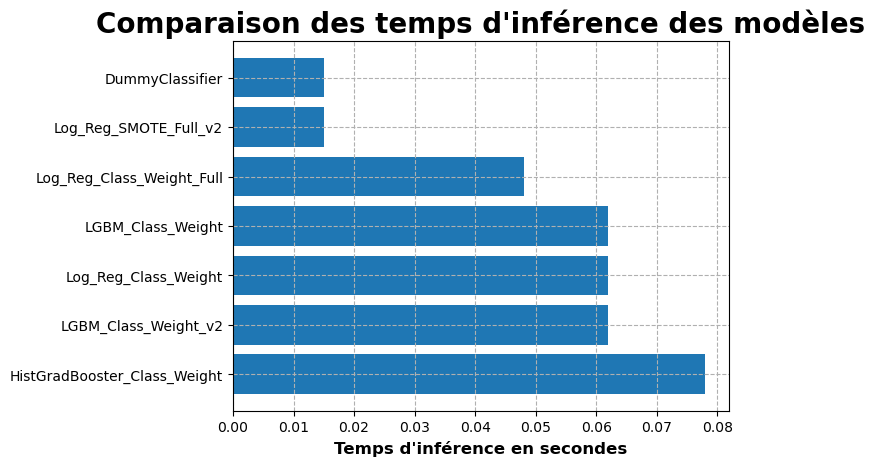

In [54]:
#Comparaison des temps d'inférence

plt.title("Comparaison des temps d'inférence des modèles", size = 20, weight = 'bold')
plt.barh(y = inference_df_2['model'].values, width = inference_df_2['times'].values)
plt.xlabel("Temps d'inférence en secondes", size = 12, weight = 'bold')
plt.grid(True, ls = '--')

## 2.2- Comparaison des temps d'entraînement

In [55]:
#Projection sur la colonne Training_time

training_time_df = metrics_df[['Training_time']]
training_time_df

,Training_time
HistGradBooster_Class_Weight,12.892865180969238
Log_Reg_SMOTE_Full_v2,8.88711166381836
LGBM_Class_Weight_v2,12.115844964981079
DummyClassifier,0.01562356948852539
Log_Reg_Class_Weight,12.217413187026978
Log_Reg_Class_Weight_Full,10.977183818817139
LGBM_Class_Weight,10.947654485702515


In [57]:
#Gestion des longueurs de temps affichés

training_times_str = []
for i in training_time_df[['Training_time']].values[:,0].astype(str):
    training_times_str.append(i[:5])
training_time_float = np.array(training_times_str).astype(float)
training_time_float

array([12.89 ,  8.887, 12.11 ,  0.015, 12.21 , 10.97 , 10.94 ])

In [58]:
#Création deuxième dataframe

training_df_2 = pd.DataFrame({'times' : training_time_float, 'model' : inference_df.index}).sort_values(by = 'times', ascending = False)
training_df_2

,times,model
0,12.890,HistGradBooster_Class_Weight
4,12.210,Log_Reg_Class_Weight
2,12.110,LGBM_Class_Weight_v2
5,10.970,Log_Reg_Class_Weight_Full
6,10.940,LGBM_Class_Weight
1,8.887,Log_Reg_SMOTE_Full_v2
3,0.015,DummyClassifier


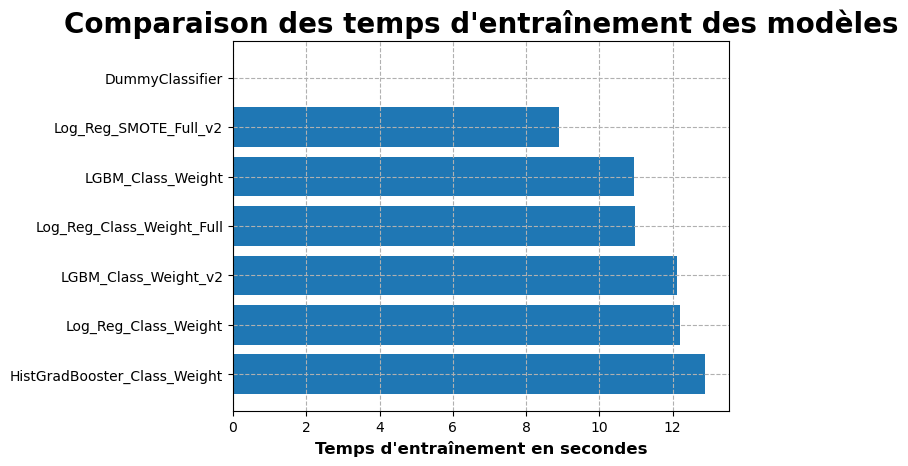

In [60]:
#Comparaison des temps d'inférence

plt.title("Comparaison des temps d'entraînement des modèles", size = 20, weight = 'bold')
plt.barh(y = training_df_2['model'].values, width = training_df_2['times'].values)
plt.xlabel("Temps d'entraînement en secondes", size = 12, weight = 'bold')
plt.grid(True, ls = '--')

## 2.3- Comparaison des métriques classiques à l'entraînement

In [63]:
#Projection sur les métriques classiques à l'entraînement

train_classic_metrics = metrics_df[['Train_ACC', 'Train_REC', 'Train_F1', 'Train_AUC']]
train_classic_metrics

,Train_ACC,Train_REC,Train_F1,Train_AUC
HistGradBooster_Class_Weight,0.712729416068779,0.7242195367573011,0.2892916046502273,0.7179699465828999
Log_Reg_SMOTE_Full_v2,0.8308530314424504,0.3180261832829809,0.23287797503825378,0.5969577731511414
LGBM_Class_Weight_v2,0.6827381557285421,0.6669184290030211,0.25340067726568327,0.6755229346810413
DummyClassifier,0.9192699335379362,0.0,0.0,0.5
Log_Reg_Class_Weight,0.681628422186541,0.668982880161128,0.25332481671798884,0.6758609154171843
Log_Reg_Class_Weight_Full,0.681445499075222,0.6691842900302115,0.25327311188611284,0.6758532827806986
LGBM_Class_Weight,0.6828682343854799,0.6661127895266868,0.253249612343741,0.7364968372763538


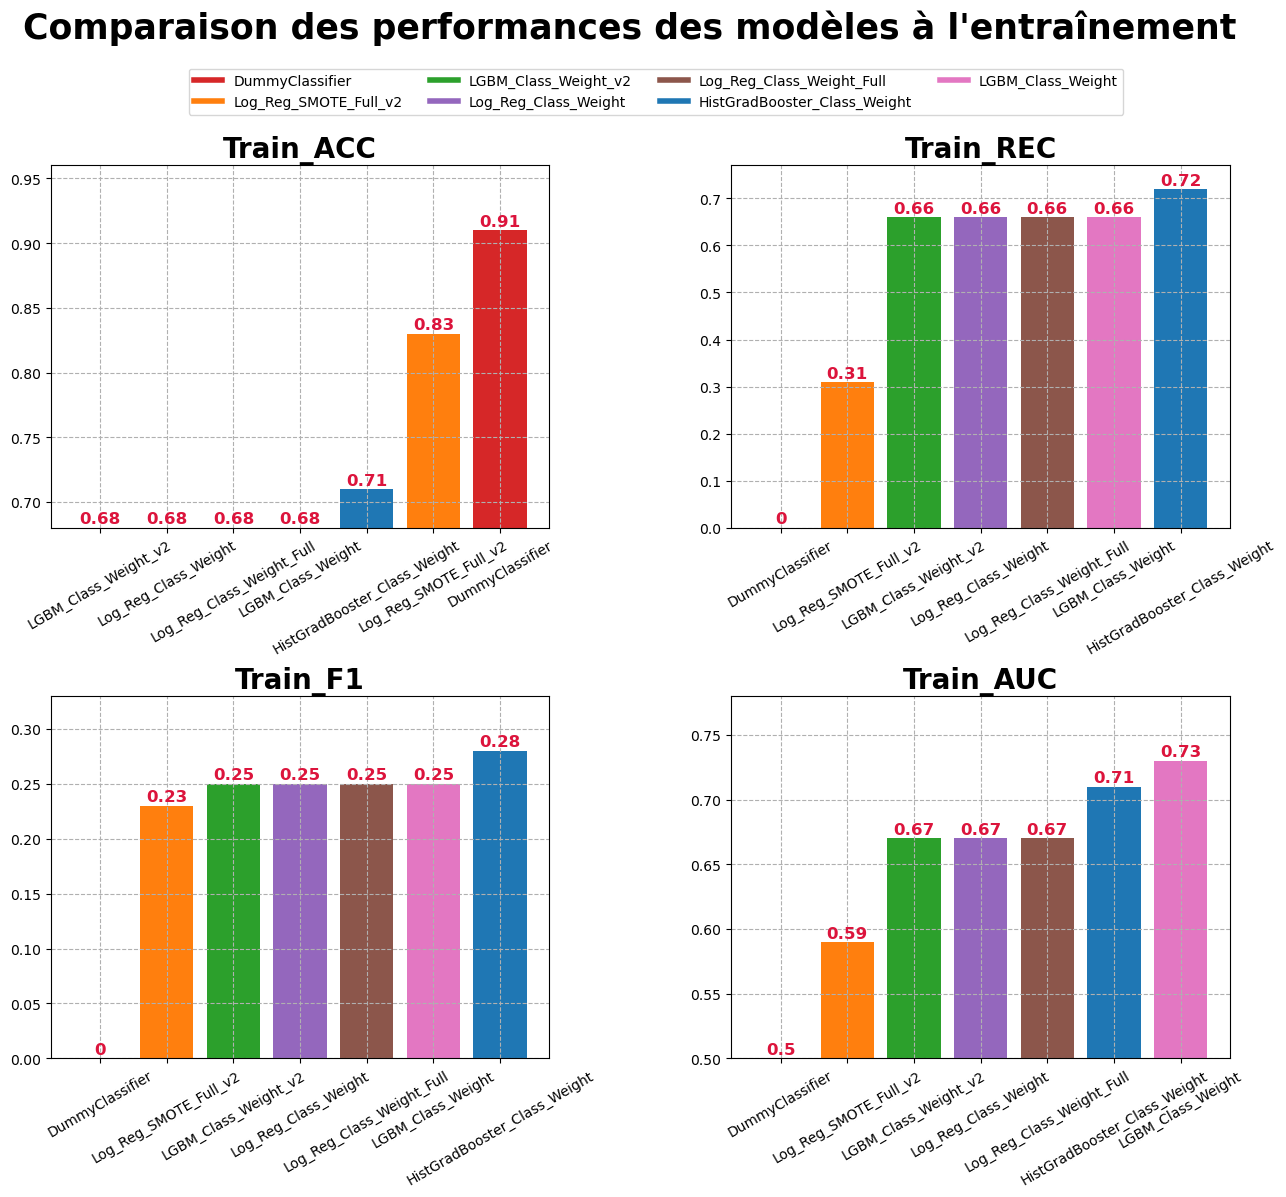

In [209]:
#Comparaison des résultats par métrique
from matplotlib.lines import Line2D

cmap = sns.color_palette("tab10")[:len(train_classic_metrics.index)]

fig, axes = plt.subplots(2,2, figsize = (15,12))
plt.rcParams.update({'font.size' : 10})
fig.tight_layout(pad=10.0)
fig.suptitle("Comparaison des performances des modèles à l'entraînement", size = 25, weight = 'bold', y = 1.01)
for i, ax in zip(train_classic_metrics.columns, axes.ravel()):
    height_str = train_classic_metrics[i].values.astype(str)
    height = []
    for j in height_str:
        height.append(j[:4])
    height = np.array(height).astype(float)
    tmp_df = pd.DataFrame({'model' : train_classic_metrics.index, 'values' : height, 'cmap' : cmap}).sort_values(by = 'values')
    bar = ax.bar(x = tmp_df['model'].values, height = tmp_df['values'].values, color = tmp_df['cmap'].values)
    ax.bar_label(bar, padding=1, color = 'crimson', weight = 'bold', size = 12)
    ax.set_title(i, size = 20, weight = 'bold')
    ax.grid(True, ls = '--')
    ax.set_xticklabels(tmp_df['model'].values, rotation = 30)
    ax.set_ylim(bottom = np.min(height), top = np.max(height) + 0.05)
    
    if i == train_classic_metrics.columns[-1]:
        colors = tmp_df['cmap']
        models = tmp_df['model']
        custom_lines = []
        for i in colors:
            custom_lines.append(Line2D([0], [0], color=i, lw=4))
        ax.legend(custom_lines, models, ncol = 4, bbox_to_anchor=(0.8, 2.75))

## 2.4- Comparaison des métriques classiques en généralisation

In [205]:
#Projection sur les métriques classiques sur le jeu de données de test

test_classic_metrics = metrics_df[['Test_ACC', 'Test_REC', 'Test_F1', 'Test_AUC']]
test_classic_metrics

,Test_ACC,Test_REC,Test_F1,Test_AUC
HistGradBooster_Class_Weight,0.7012942668531105,0.6235649546827795,0.2520864715222082,0.6658426503254533
Log_Reg_SMOTE_Full_v2,0.8301193457123346,0.3081570996978852,0.2265324252294936,0.5920572186852798
LGBM_Class_Weight_v2,0.6809209456603037,0.6404833836858006,0.24476600985221675,0.662477749645755
DummyClassifier,0.9192709180189262,0.0,0.0,0.5
Log_Reg_Class_Weight,0.6798803290949887,0.6469284994964754,0.2460171568627451,0.664851306012277
Log_Reg_Class_Weight_Full,0.67962017495366,0.6473313192346425,0.24598193785397213,0.6648935280928329
LGBM_Class_Weight,0.6807746089558063,0.6410876132930513,0.24485557136812955,0.7208225268835793


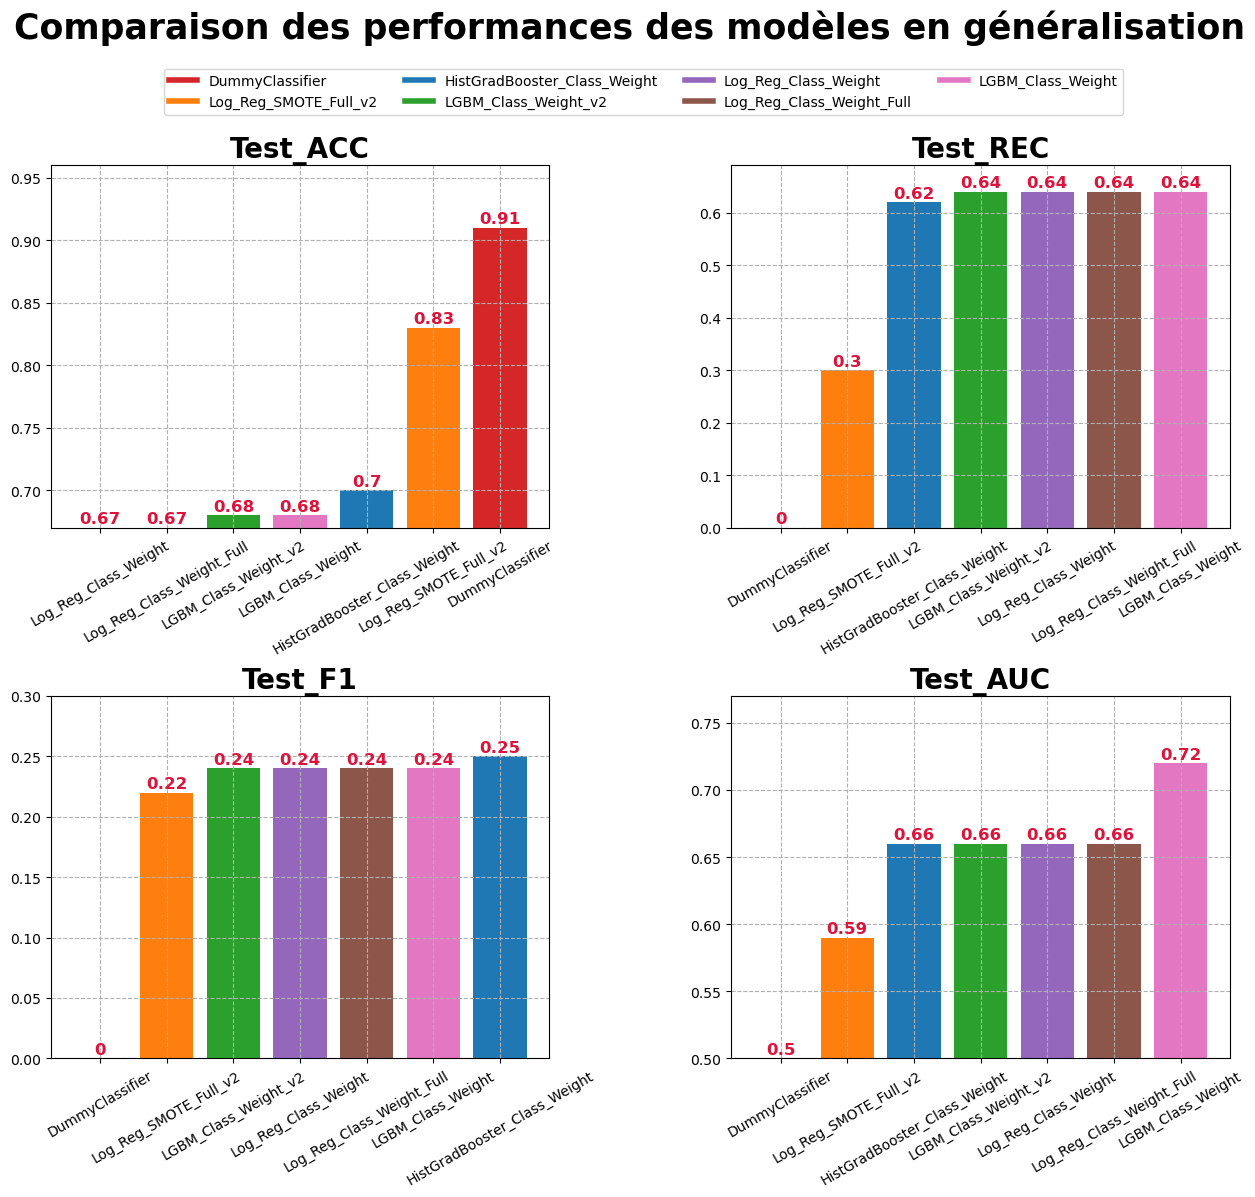

In [210]:
#Comparaison des résultats par métrique
from matplotlib.lines import Line2D

cmap = sns.color_palette("tab10")[:len(test_classic_metrics.index)]

fig, axes = plt.subplots(2,2, figsize = (15,12))
plt.rcParams.update({'font.size' : 10})
fig.tight_layout(pad=10.0)
fig.suptitle("Comparaison des performances des modèles en généralisation", size = 25, weight = 'bold', y = 1.01)
for i, ax in zip(test_classic_metrics.columns, axes.ravel()):
    height_str = test_classic_metrics[i].values.astype(str)
    height = []
    for j in height_str:
        height.append(j[:4])
    height = np.array(height).astype(float)
    tmp_df = pd.DataFrame({'model' : test_classic_metrics.index, 'values' : height, 'cmap' : cmap}).sort_values(by = 'values')
    bar = ax.bar(x = tmp_df['model'].values, height = tmp_df['values'].values, color = tmp_df['cmap'].values)
    ax.bar_label(bar, padding=1, color = 'crimson', weight = 'bold', size = 12)
    ax.set_title(i, size = 20, weight = 'bold')
    ax.grid(True, ls = '--')
    ax.set_xticklabels(tmp_df['model'].values, rotation = 30)
    ax.set_ylim(bottom = np.min(height), top = np.max(height) + 0.05)
    
    if i == test_classic_metrics.columns[-1]:
        colors = tmp_df['cmap']
        models = tmp_df['model']
        custom_lines = []
        for i in colors:
            custom_lines.append(Line2D([0], [0], color=i, lw=4))
        ax.legend(custom_lines, models, ncol = 4, bbox_to_anchor=(0.8, 2.75))

## 2.5- Comparaison des scores métier

In [212]:
#Projection sur les scores

score_metrics = metrics_df[['Train_custom_score', 'Test_custom_score']]
score_metrics

,Train_custom_score,Test_custom_score
HistGradBooster_Class_Weight,-0.4876445600699173,-0.5722090338525576
Log_Reg_SMOTE_Full_v2,-0.66464909249812,-0.672547234236285
LGBM_Class_Weight_v2,-0.5592691205463304,-0.5802900718675815
DummyClassifier,-0.8073006646206378,-0.8072908198107379
Log_Reg_Class_Weight,-0.5588788845755167,-0.5766479138889792
Log_Reg_Class_Weight_Full,-0.5589154691977806,-0.5766153946213132
LGBM_Class_Weight,-0.5597243958456128,-0.5799973984585867


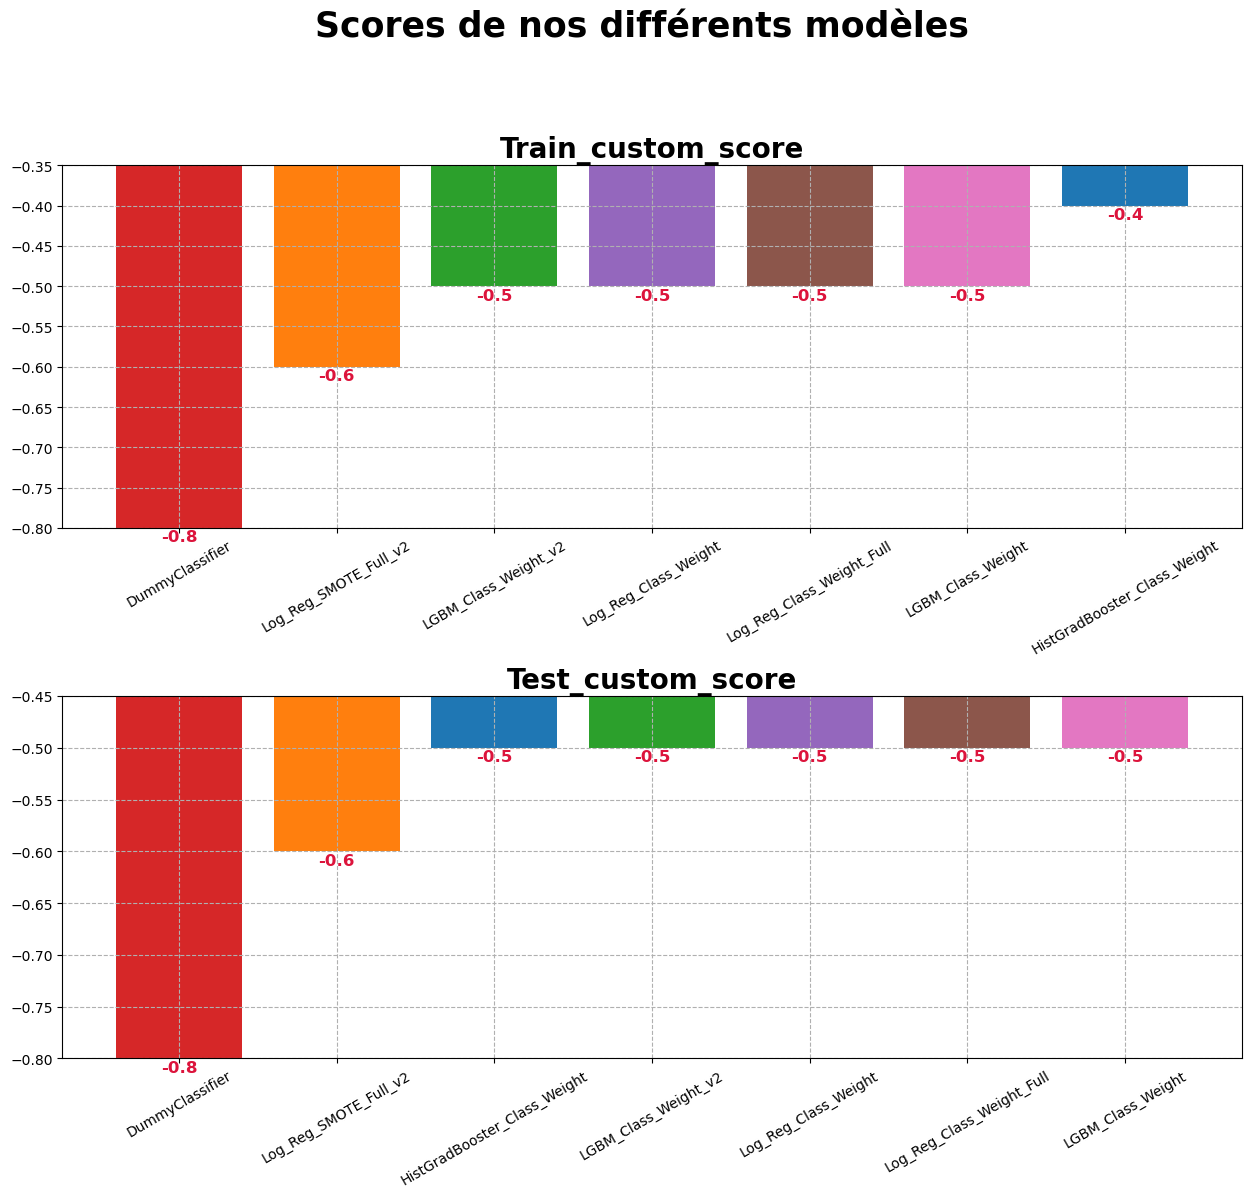

In [214]:
#Comparaison des résultats par métrique
from matplotlib.lines import Line2D

cmap = sns.color_palette("tab10")[:len(score_metrics.index)]

fig, axes = plt.subplots(2,1, figsize = (15,12))
plt.rcParams.update({'font.size' : 10})
fig.tight_layout(pad=10.0)
fig.suptitle("Scores de nos différents modèles", size = 25, weight = 'bold', y = 1.01)
for i, ax in zip(score_metrics.columns, axes.ravel()):
    height_str = score_metrics[i].values.astype(str)
    height = []
    for j in height_str:
        height.append(j[:4])
    height = np.array(height).astype(float)
    tmp_df = pd.DataFrame({'model' : score_metrics.index, 'values' : height, 'cmap' : cmap}).sort_values(by = 'values')
    bar = ax.bar(x = tmp_df['model'].values, height = tmp_df['values'].values, color = tmp_df['cmap'].values)
    ax.bar_label(bar, padding=1, color = 'crimson', weight = 'bold', size = 12)
    ax.set_title(i, size = 20, weight = 'bold')
    ax.grid(True, ls = '--')
    ax.set_xticklabels(tmp_df['model'].values, rotation = 30)
    ax.set_ylim(bottom = np.min(height), top = np.max(height) + 0.05)
    
    if i == test_classic_metrics.columns[-1]:
        colors = tmp_df['cmap']
        models = tmp_df['model']
        custom_lines = []
        for i in colors:
            custom_lines.append(Line2D([0], [0], color=i, lw=4))
        ax.legend(custom_lines, models, ncol = 4, bbox_to_anchor=(0.8, 2.75))

# 3- Interprétation des modèles

## 3.1- Interprétation globale

In [218]:
#Affichage des run et importation de Images de PIL
from PIL import Image

run_dict

{'HistGradBooster_Class_Weight': '24ac298a81f4400c8f804cda23fcd1c8',
 'Log_Reg_SMOTE_Full_v2': '71a400e8463d4cffb924cc71c19b0323',
 'LGBM_Class_Weight_v2': '75ed012842494ec7ba9ca32fc3ac850e',
 'DummyClassifier': '9ec0fff9adf3444db32e0380b1e19d57',
 'Log_Reg_Class_Weight': 'a016e1946504488ba1fba6cd28c2a49d',
 'Log_Reg_Class_Weight_Full': 'e046c700b1814f5e87c650122816ebba',
 'LGBM_Class_Weight': 'ede672b9c1d74e64aace66b26dd39161'}

(-0.5, 1809.5, 1274.5, -0.5)

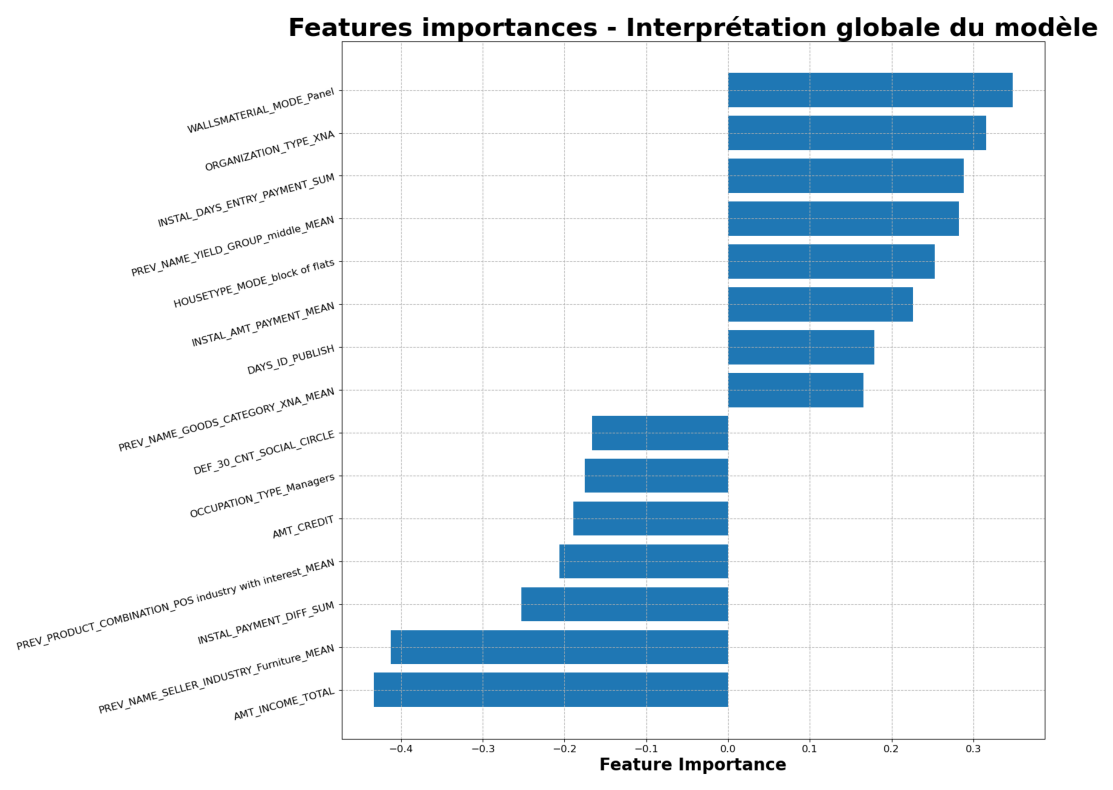

In [224]:
#Chargement de l'interprétation globale d'une régression logistique

log_reg_id = run_dict['Log_Reg_Class_Weight_Full']
importance_path = 'mlruns/' + exp_id + '/' + log_reg_id + '/artifacts/feature_importance/feature_importances.png'
log_reg_importance_image = Image.open(importance_path)
plt.figure(figsize = (15,10))
plt.imshow(log_reg_importance_image)
plt.axis('off')

(-0.5, 1776.5, 1274.5, -0.5)

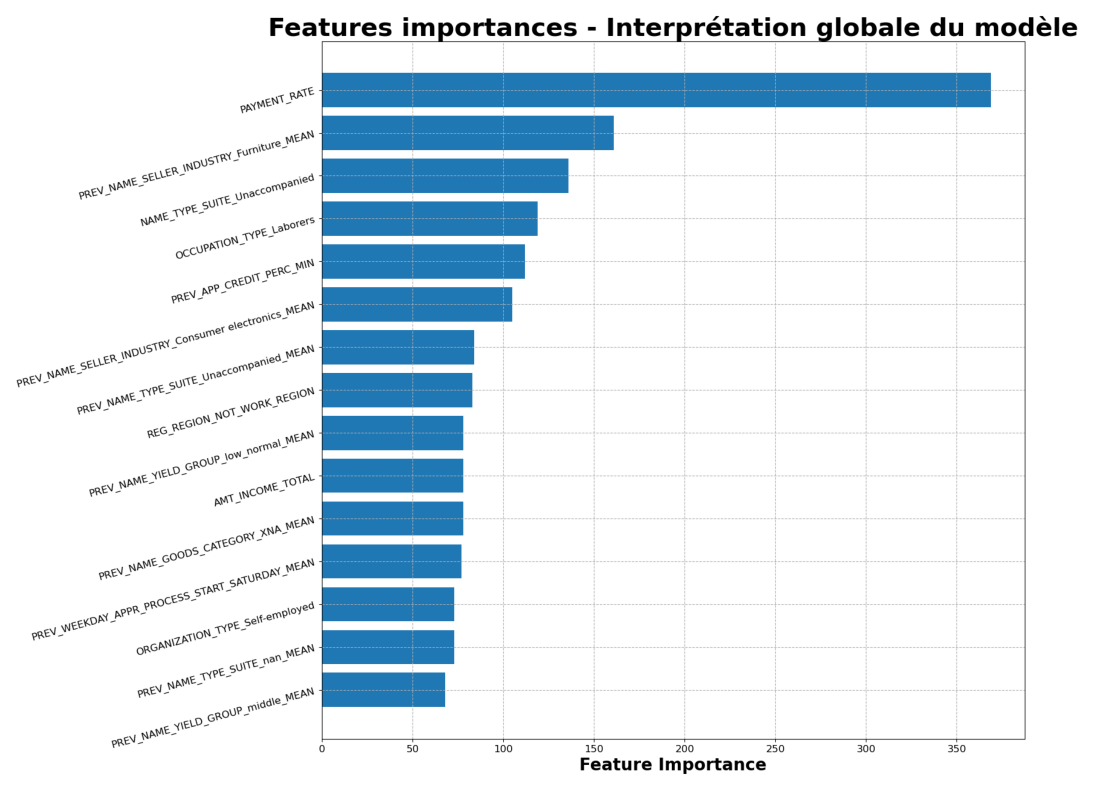

In [226]:
#Chargement de l'interprétation globale d'un LGBMClassifier

LGBM_id = run_dict['LGBM_Class_Weight']
importance_path = 'mlruns/' + exp_id + '/' + LGBM_id + '/artifacts/feature_importance/feature_importances.png'
LGBM_importance_image = Image.open(importance_path)
plt.figure(figsize = (15,10))
plt.imshow(log_reg_importance_image)
plt.axis('off')

(-0.5, 1715.5, 1274.5, -0.5)

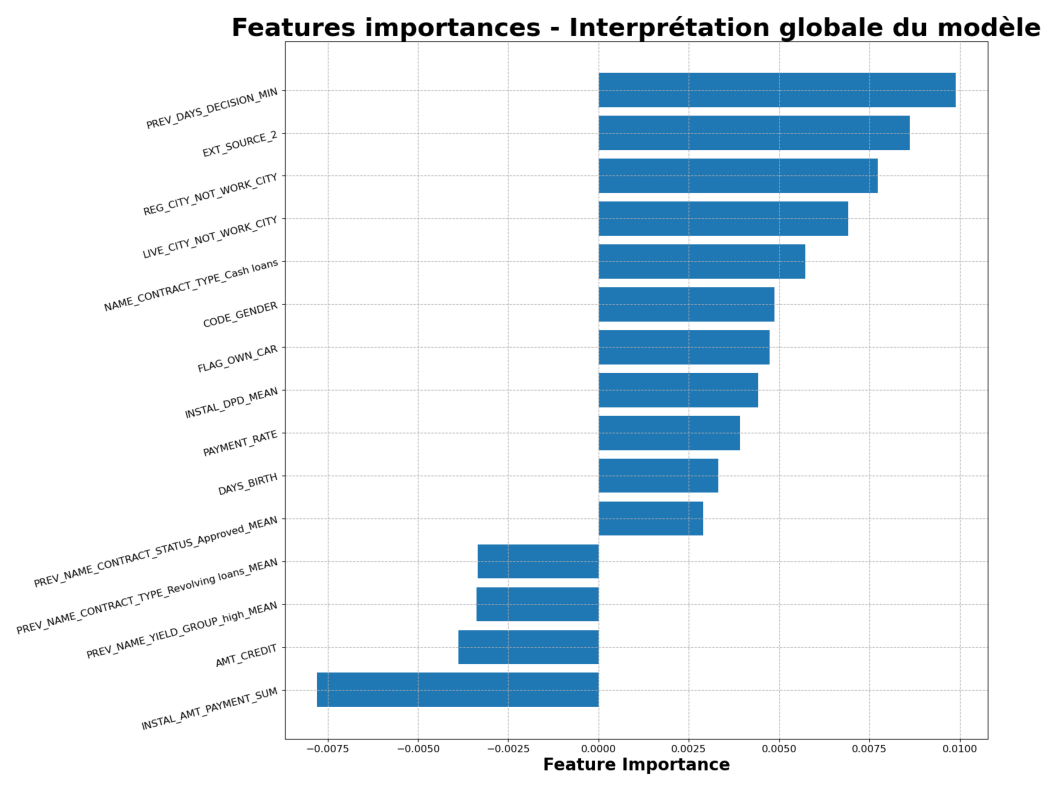

In [227]:
#Chargement de l'interprétation globale d'un HistGradientBoostingClassfifer

Hist_id = run_dict['HistGradBooster_Class_Weight']
importance_path = 'mlruns/' + exp_id + '/' + Hist_id + '/artifacts/feature_importance/feature_importances.png'
hist_importance_image = Image.open(importance_path)
plt.figure(figsize = (15,10))
plt.imshow(log_reg_importance_image)
plt.axis('off')

## 3.2- Interprétation locale

In [228]:
#Importation de shap et mlflow

import shap
import mlflow

In [230]:
#Importation du modèle, du seuil de classification, et des jeux ed donénes X_train, y_train, X_test et y_test

model_path = 'mlruns/' + exp_id + '/' + LGBM_id + '/artifacts/' + exp_name + '_' + 'LGBM_Class_Weight' + '_Classifier'
best_thresh = open("mlruns/" + exp_id + '/' + LGBM_id + '/params/classifier__threshold').read()
best_thresh = float(best_thresh)

model = mlflow.lightgbm.load_model(model_path)
X_train = pd.read_pickle('mlruns/' + exp_id + '/' + LGBM_id + '/artifacts/train_test/X_train.pkl')
X_test = pd.read_pickle('mlruns/' + exp_id + '/' + LGBM_id + '/artifacts/train_test/X_test.pkl')
y_train = pd.read_pickle('mlruns/' + exp_id + '/' + LGBM_id + '/artifacts/train_test/y_train.pkl')
y_test = pd.read_pickle('mlruns/' + exp_id + '/' + LGBM_id + '/artifacts/train_test/y_test.pkl')

In [282]:
#Mise en place du shap explainer, avec la méthode predict_proba du modèle

shap_explainer = shap.KernelExplainer(model.predict_proba, shap.kmeans(X_train.sample(10000), 100))

In [244]:
#Sélection d'un individu en particulier et affichage des features prenant une valeurs non nulle

obs_0 = X_test.iloc[0]
non_null_features = obs_0.loc[obs_0!=0].sort_values().index
non_null_features

Index(['DAYS_BIRTH', 'INSTAL_DAYS_ENTRY_PAYMENT_SUM', 'DAYS_REGISTRATION',
       'DAYS_ID_PUBLISH', 'PREV_DAYS_DECISION_MIN', 'DAYS_LAST_PHONE_CHANGE',
       'PAYMENT_RATE', 'REGION_POPULATION_RELATIVE', 'ANNUITY_INCOME_PERC',
       'PREV_NAME_CONTRACT_STATUS_Unused offer_MEAN',
       'PREV_NAME_PRODUCT_TYPE_walk-in_MEAN',
       'PREV_NAME_YIELD_GROUP_low_normal_MEAN',
       'PREV_WEEKDAY_APPR_PROCESS_START_SUNDAY_MEAN',
       'PREV_WEEKDAY_APPR_PROCESS_START_TUESDAY_MEAN',
       'PREV_NAME_TYPE_SUITE_Family_MEAN',
       'PREV_WEEKDAY_APPR_PROCESS_START_SATURDAY_MEAN',
       'PREV_NAME_TYPE_SUITE_Unaccompanied_MEAN',
       'PREV_CHANNEL_TYPE_Country-wide_MEAN',
       'PREV_NAME_SELLER_INDUSTRY_Connectivity_MEAN',
       'PREV_NAME_PAYMENT_TYPE_Cash through the bank_MEAN',
       'PREV_NAME_CONTRACT_STATUS_Approved_MEAN',
       'PREV_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_MEAN',
       'PREV_WEEKDAY_APPR_PROCESS_START_MONDAY_MEAN',
       'PREV_NAME_CONTRACT_TYPE_Revolving lo

In [256]:
#Affichage des features_improtance des individus avec une feature importance non nulle

features_importances = pd.DataFrame(model[-1].feature_importances_, index = X_train.columns, columns = ['importance'])
features_importances = features_importances.sort_values(by = 'importance', ascending = False)
features_importances

,importance
PAYMENT_RATE,369
PREV_NAME_SELLER_INDUSTRY_Furniture_MEAN,161
NAME_TYPE_SUITE_Unaccompanied,136
OCCUPATION_TYPE_Laborers,119
PREV_APP_CREDIT_PERC_MIN,112
...,...
PREV_NAME_PAYMENT_TYPE_Non-cash from your account_MEAN,0
PREV_NAME_GOODS_CATEGORY_Auto Accessories_MEAN,0
PREV_NAME_CONTRACT_STATUS_Unused offer_MEAN,0
PREV_CHANNEL_TYPE_Stone_MEAN,0


In [257]:
#Reprennons la liste des features importants

important_feats = features_importances.loc[features_importances['importance']>0].index

In [259]:
#Affichons les individus projettés sur ces features sur notre observation

obs_0[important_feats].sort_values()

INSTAL_DAYS_ENTRY_PAYMENT_SUM         -9692.0
DAYS_REGISTRATION                     -5400.0
DAYS_ID_PUBLISH                       -2664.0
PREV_DAYS_DECISION_MIN                -2484.0
PREV_NAME_YIELD_GROUP_high_MEAN           0.0
                                      ...    
INSTAL_AMT_PAYMENT_MIN                 5940.9
INSTAL_AMT_PAYMENT_MEAN            5944.84875
INSTAL_AMT_PAYMENT_SUM              23779.395
AMT_INCOME_TOTAL                     346500.0
AMT_CREDIT                           810000.0
Name: 104389, Length: 85, dtype: object

Text(910000.0, 15000, '810000.0')

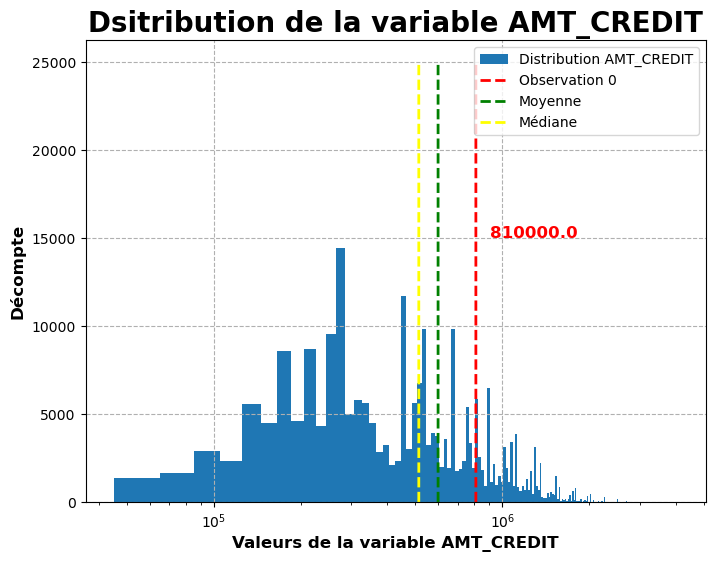

In [275]:
#Comparaison de l'individu 0 au sein de la variable AMT_CREDIT

plt.figure(figsize = (8,6))
plt.title('Dsitribution de la variable AMT_CREDIT', size = 20, weight = 'bold')
h = plt.hist(X_train['AMT_CREDIT'].values, bins = 200, label = 'Distribution AMT_CREDIT')
plt.plot(np.linspace(obs_0['AMT_CREDIT'], obs_0['AMT_CREDIT'], len(X_train)), np.linspace(0, 25000, len(X_train)),
        lw = 2, color = 'red', ls = '--', label = 'Observation 0')
plt.plot(np.linspace(X_train['AMT_CREDIT'].mean(), X_train['AMT_CREDIT'].mean(), len(X_train)), np.linspace(0, 25000, len(X_train)),
        lw = 2, color = 'green', ls = '--', label = 'Moyenne')
plt.plot(np.linspace(X_train['AMT_CREDIT'].median(), X_train['AMT_CREDIT'].median(), len(X_train)), np.linspace(0, 25000, len(X_train)),
        lw = 2, color = 'yellow', ls = '--', label = 'Médiane')
plt.xscale('log')
plt.legend(loc = 'upper right')
plt.xlabel('Valeurs de la variable AMT_CREDIT', size = 12, weight = 'bold')
plt.ylabel('Décompte', size = 12, weight = 'bold')
plt.grid(True, ls = '--')
plt.text(obs_0['AMT_CREDIT'] + 100000, 15000, '{}'.format(obs_0['AMT_CREDIT']), color = 'red', size = 12, weight = 'bold')

Text(446500.0, 15000, '346500.0')

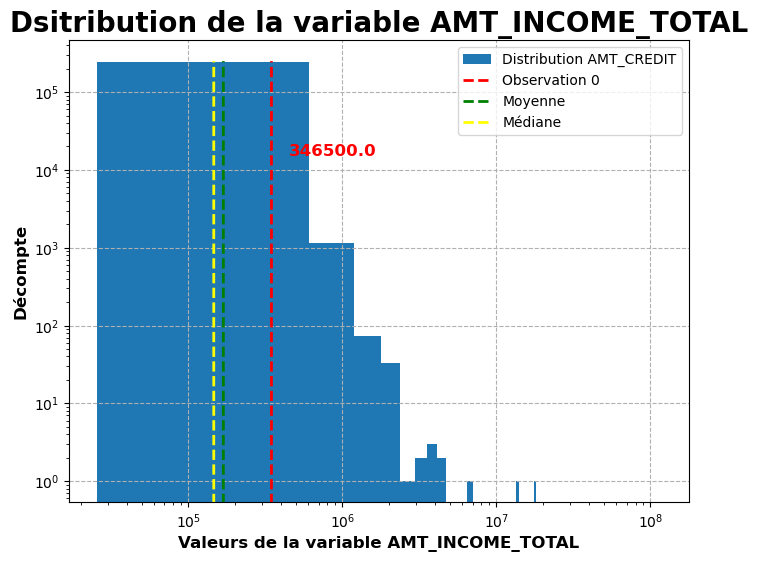

In [279]:
#Comparaison de l'individu 0 au sein de la variable AMT_INCOME_TOTAL

plt.figure(figsize = (8,6))
plt.title('Dsitribution de la variable AMT_INCOME_TOTAL', size = 20, weight = 'bold')
h = plt.hist(X_train['AMT_INCOME_TOTAL'].values, bins = 200, label = 'Distribution AMT_CREDIT')
plt.plot(np.linspace(obs_0['AMT_INCOME_TOTAL'], obs_0['AMT_INCOME_TOTAL'], len(X_train)), np.linspace(0, 250000, len(X_train)),
        lw = 2, color = 'red', ls = '--', label = 'Observation 0')
plt.plot(np.linspace(X_train['AMT_INCOME_TOTAL'].mean(), X_train['AMT_INCOME_TOTAL'].mean(), len(X_train)), np.linspace(0, 250000, len(X_train)),
        lw = 2, color = 'green', ls = '--', label = 'Moyenne')
plt.plot(np.linspace(X_train['AMT_INCOME_TOTAL'].median(), X_train['AMT_INCOME_TOTAL'].median(), len(X_train)), np.linspace(0, 250000, len(X_train)),
        lw = 2, color = 'yellow', ls = '--', label = 'Médiane')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc = 'upper right')
plt.xlabel('Valeurs de la variable AMT_INCOME_TOTAL', size = 12, weight = 'bold')
plt.ylabel('Décompte', size = 12, weight = 'bold')
plt.grid(True, ls = '--')
plt.text(obs_0['AMT_INCOME_TOTAL'] + 100000, 15000, '{}'.format(obs_0['AMT_INCOME_TOTAL']), color = 'red', size = 12, weight = 'bold')

Text(0.030238888888888888, 15000, '0.02')

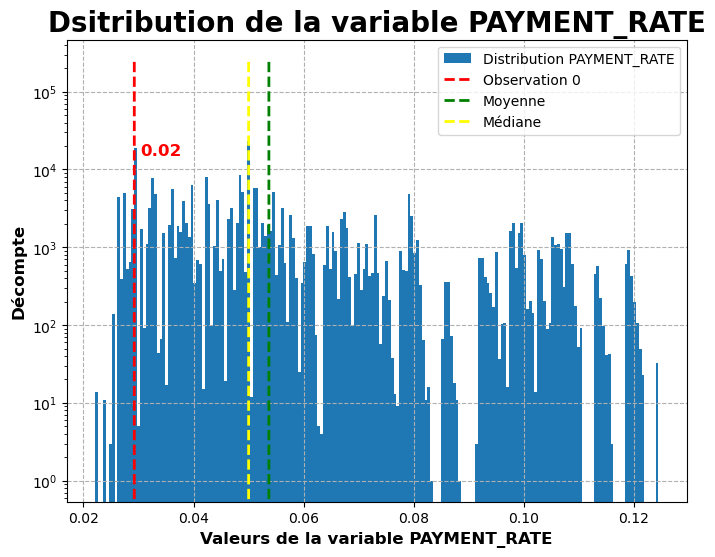

In [296]:
#Comparaison de l'individu 0 au sein de la variable PAYEMENT_RATE

plt.figure(figsize = (8,6))
plt.title('Dsitribution de la variable PAYMENT_RATE', size = 20, weight = 'bold')
h = plt.hist(X_train['PAYMENT_RATE'].values, bins = 200, label = 'Distribution PAYMENT_RATE')
plt.plot(np.linspace(obs_0['PAYMENT_RATE'], obs_0['PAYMENT_RATE'], len(X_train)), np.linspace(0, 250000, len(X_train)),
        lw = 2, color = 'red', ls = '--', label = 'Observation 0')
plt.plot(np.linspace(X_train['PAYMENT_RATE'].mean(), X_train['PAYMENT_RATE'].mean(), len(X_train)), np.linspace(0, 250000, len(X_train)),
        lw = 2, color = 'green', ls = '--', label = 'Moyenne')
plt.plot(np.linspace(X_train['PAYMENT_RATE'].median(), X_train['PAYMENT_RATE'].median(), len(X_train)), np.linspace(0, 250000, len(X_train)),
        lw = 2, color = 'yellow', ls = '--', label = 'Médiane')
plt.yscale('log')
plt.legend(loc = 'upper right')
plt.xlabel('Valeurs de la variable PAYMENT_RATE', size = 12, weight = 'bold')
plt.ylabel('Décompte', size = 12, weight = 'bold')
plt.grid(True, ls = '--')
plt.text(obs_0['PAYMENT_RATE'] + 0.001, 15000, '{}'.format(str(obs_0['PAYMENT_RATE'])[:4]), color = 'red', size = 12, weight = 'bold')

In [285]:
#Calcul des shap_values de notre individu

shap_values = list(shap_explainer.shap_values(obs_0.values)[0])
shap_values_df = pd.DataFrame(shap_values, index = X_train.columns, columns = ['Values'])
shap_values_df

,Values
PREV_NAME_GOODS_CATEGORY_Education_MEAN,0.000000
POS_NAME_CONTRACT_STATUS_Demand_MEAN,0.000000
PREV_NAME_CASH_LOAN_PURPOSE_Buying a home_MEAN,0.000000
PREV_NAME_CASH_LOAN_PURPOSE_Payments on other loans_MEAN,0.000000
PREV_CHANNEL_TYPE_Car dealer_MEAN,0.000000
...,...
AMT_INCOME_TOTAL,0.000000
AMT_CREDIT,0.000000
INSTAL_AMT_PAYMENT_SUM,-0.000116
INSTAL_PAYMENT_PERC_VAR,0.000000


In [288]:
#Projection sur les valeurs non nulles

shap_values_non_null = shap_values_df.loc[shap_values_df['Values'] !=0].sort_values(by = 'Values', ascending = False)
shap_values_non_null

,Values
PAYMENT_RATE,0.000187
INSTAL_DPD_MEAN,0.000101
DAYS_LAST_PHONE_CHANGE,0.000100
PREV_APP_CREDIT_PERC_MIN,0.000072
INSTAL_DPD_SUM,0.000043
INSTAL_DPD_MAX,0.000043
INSTAL_DAYS_ENTRY_PAYMENT_SUM,-0.000093
EXT_SOURCE_2,-0.000111
INSTAL_AMT_PAYMENT_SUM,-0.000116
PREV_NAME_CONTRACT_STATUS_Approved_MEAN,-0.000188


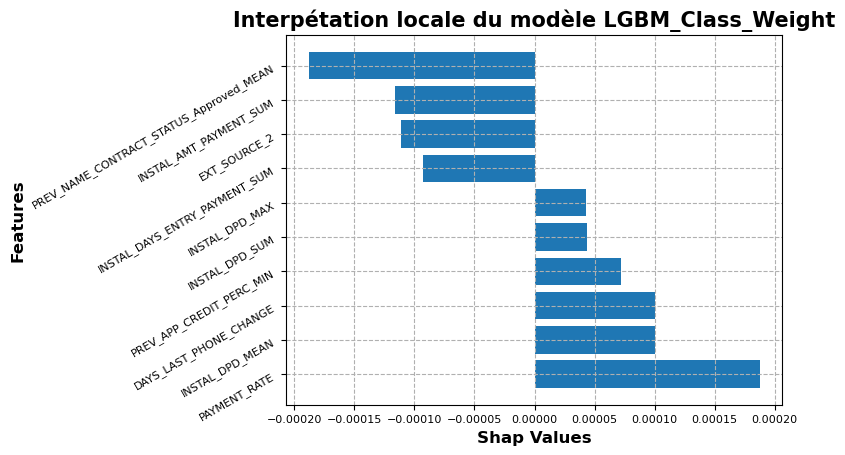

In [314]:
#Affichage des shap values

plt.rcParams.update({'font.size' : 8})
plt.title('Interpétation locale du modèle LGBM_Class_Weight', size = 15, weight = 'bold')
plt.barh(y = shap_values_non_null.index, width = shap_values_non_null['Values'].values)
plt.grid(True, ls = '--')
plt.xlabel('Shap Values', size = 12, weight = 'bold')
plt.ylabel('Features', size = 12, weight = 'bold')
y = plt.yticks(rotation = 30)

In [323]:
#Prédiction d'appartenance à la classe 1

obs_0_prediction_proba = model.predict_proba(X_test.loc[X_test.index == 0])[:,1]
prediction = int(obs_0_prediction_proba > best_thresh)
print("Le seuil de prédiction est fixé à : {}".format(best_thresh))
print("Nous avons {}% de chances de défauts de paiement.".format(str(obs_0_prediction_proba[0]*100)[:7]))
print("Le modèle effectue donc la prédiction : classe {}.".format(prediction))

Le seuil de prédiction est fixé à : 0.5
Nous avons 50.0265% de chances de défauts de paiement.
Le modèle effectue donc la prédiction : classe 1.


Text(0.201, 15000, '0.2')

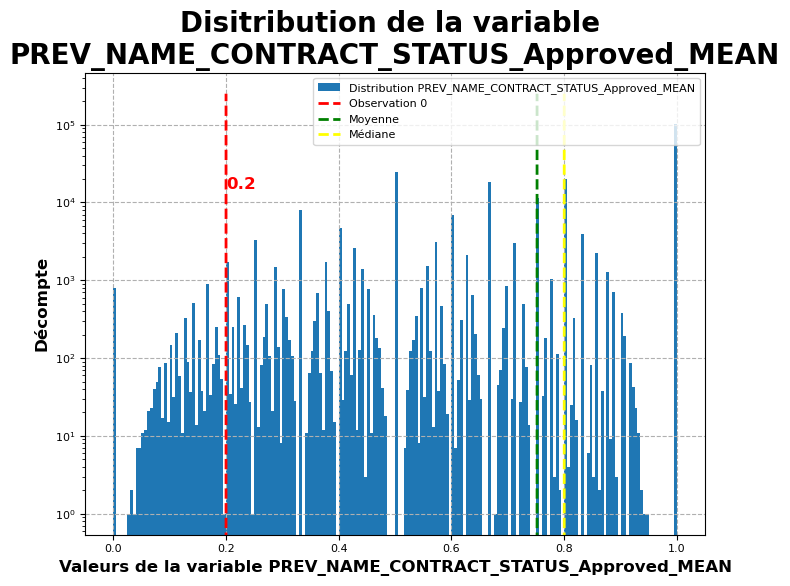

In [325]:
#Comparaison de l'individu 0 au sein de la variable PREV_NAME_CONTRACT_STATUS_Approved_MEAN

plt.figure(figsize = (8,6))
plt.title('Disitribution de la variable \nPREV_NAME_CONTRACT_STATUS_Approved_MEAN', size = 20, weight = 'bold')
h = plt.hist(X_train['PREV_NAME_CONTRACT_STATUS_Approved_MEAN'].values, bins = 200, label = 'Distribution PREV_NAME_CONTRACT_STATUS_Approved_MEAN')
plt.plot(np.linspace(obs_0['PREV_NAME_CONTRACT_STATUS_Approved_MEAN'], obs_0['PREV_NAME_CONTRACT_STATUS_Approved_MEAN'], len(X_train)), np.linspace(0, 250000, len(X_train)),
        lw = 2, color = 'red', ls = '--', label = 'Observation 0')
plt.plot(np.linspace(X_train['PREV_NAME_CONTRACT_STATUS_Approved_MEAN'].mean(), X_train['PREV_NAME_CONTRACT_STATUS_Approved_MEAN'].mean(), len(X_train)), np.linspace(0, 250000, len(X_train)),
        lw = 2, color = 'green', ls = '--', label = 'Moyenne')
plt.plot(np.linspace(X_train['PREV_NAME_CONTRACT_STATUS_Approved_MEAN'].median(), X_train['PREV_NAME_CONTRACT_STATUS_Approved_MEAN'].median(), len(X_train)), np.linspace(0, 250000, len(X_train)),
        lw = 2, color = 'yellow', ls = '--', label = 'Médiane')
plt.yscale('log')
plt.legend(loc = 'upper right')
plt.xlabel('Valeurs de la variable PREV_NAME_CONTRACT_STATUS_Approved_MEAN', size = 12, weight = 'bold')
plt.ylabel('Décompte', size = 12, weight = 'bold')
plt.grid(True, ls = '--')
plt.text(obs_0['PREV_NAME_CONTRACT_STATUS_Approved_MEAN'] + 0.001, 15000, '{}'.format(str(obs_0['PREV_NAME_CONTRACT_STATUS_Approved_MEAN'])[:4]), color = 'red', size = 12, weight = 'bold')

In [337]:
#Observation aléatoire

n = X_test.index[100]
obs_100 = X_test.iloc[100]
obs_100_prediction_proba = model.predict_proba(X_test.loc[X_test.index == n])[:,1]
prediction_100 = int(obs_100_prediction_proba > best_thresh)
print("Le seuil de prédiction est fixé à : {}".format(best_thresh))
print("Nous avons {}% de chances de défauts de paiement.".format(str(obs_100_prediction_proba[0]*100)[:7]))
print("Le modèle effectue donc la prédiction : classe {}.".format(prediction_100))

Le seuil de prédiction est fixé à : 0.5
Nous avons 49.9227% de chances de défauts de paiement.
Le modèle effectue donc la prédiction : classe 0.


In [338]:
#Calcul des shap_values de notre individu

shap_values_100 = list(shap_explainer.shap_values(obs_100.values)[0])
shap_values_100 = pd.DataFrame(shap_values, index = X_train.columns, columns = ['Values'])
shap_values_100

,Values
PREV_NAME_GOODS_CATEGORY_Education_MEAN,0.000000
POS_NAME_CONTRACT_STATUS_Demand_MEAN,0.000000
PREV_NAME_CASH_LOAN_PURPOSE_Buying a home_MEAN,0.000000
PREV_NAME_CASH_LOAN_PURPOSE_Payments on other loans_MEAN,0.000000
PREV_CHANNEL_TYPE_Car dealer_MEAN,0.000000
...,...
AMT_INCOME_TOTAL,0.000000
AMT_CREDIT,0.000000
INSTAL_AMT_PAYMENT_SUM,-0.000116
INSTAL_PAYMENT_PERC_VAR,0.000000


In [339]:
#Projection sur les valeurs non nulles

shap_values_non_null_100 = shap_values_100.loc[shap_values_100['Values'] !=0].sort_values(by = 'Values', ascending = False)
shap_values_non_null_100

,Values
PAYMENT_RATE,0.000187
INSTAL_DPD_MEAN,0.000101
DAYS_LAST_PHONE_CHANGE,0.000100
PREV_APP_CREDIT_PERC_MIN,0.000072
INSTAL_DPD_SUM,0.000043
INSTAL_DPD_MAX,0.000043
INSTAL_DAYS_ENTRY_PAYMENT_SUM,-0.000093
EXT_SOURCE_2,-0.000111
INSTAL_AMT_PAYMENT_SUM,-0.000116
PREV_NAME_CONTRACT_STATUS_Approved_MEAN,-0.000188


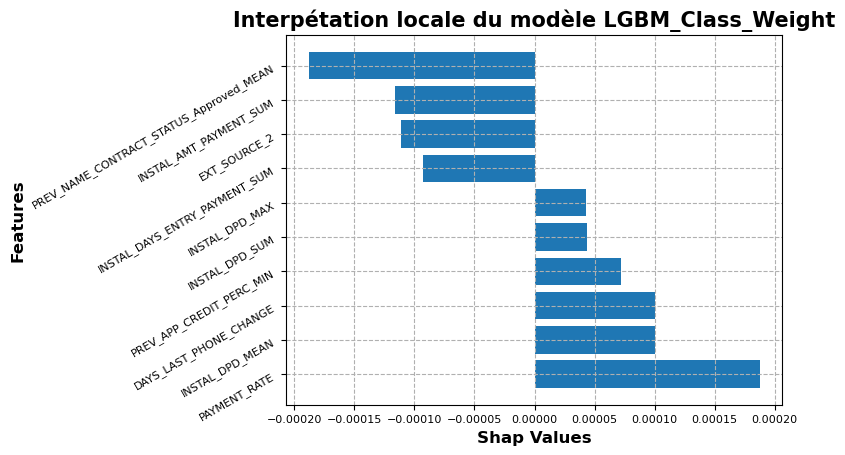

In [340]:
#Affichage des shap values

plt.rcParams.update({'font.size' : 8})
plt.title('Interpétation locale du modèle LGBM_Class_Weight', size = 15, weight = 'bold')
plt.barh(y = shap_values_non_null_100.index, width = shap_values_non_null_100['Values'].values)
plt.grid(True, ls = '--')
plt.xlabel('Shap Values', size = 12, weight = 'bold')
plt.ylabel('Features', size = 12, weight = 'bold')
y = plt.yticks(rotation = 30)

## 2.3- Utilisation du modèle sur les données de production

In [399]:
#Utilisation du modèle en inférence sur les données de production

production_class_1_proba = model.predict_proba(production)[:,1]
production_predicted_class = (production_class_1_proba > best_thresh).astype(int)
production_predicted_class

array([0, 1, 0, ..., 0, 0, 1])

Text(0.8, 20000, '36.0%')

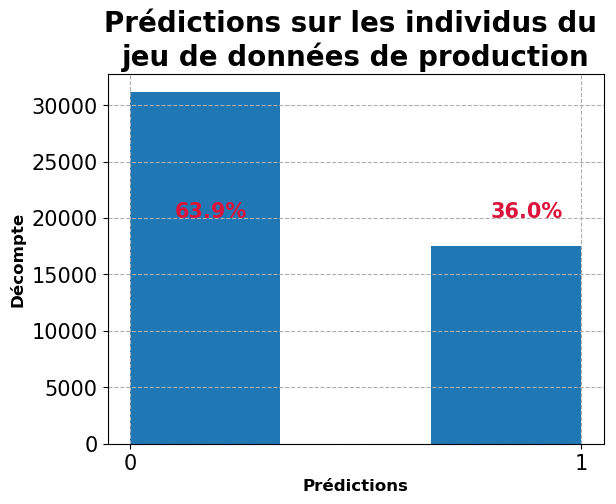

In [400]:
#Distribution des prédictions du modèle

class_0_ratio = pd.DataFrame({'A':production_predicted_class}).value_counts()[0]/len(production)
class_1_ratio = pd.DataFrame({'A':production_predicted_class}).value_counts()[1]/len(production)

plt.title("Prédictions sur les individus du \njeu de données de production", weight = 'bold', size = 20)
plt.rcParams.update({'font.size' : 15})
h = plt.hist(production_predicted_class, bins = 3)
plt.xlabel("Prédictions", size = 12, weight = 'bold')
plt.ylabel("Décompte", size = 12, weight = 'bold')
plt.grid(True, ls = '--')
tick = plt.xticks([0,1])
plt.text(0.1, 20000, "{}%".format(str(class_0_ratio*100)[:4]), color = 'crimson', weight = 'bold')
plt.text(0.8, 20000, "{}%".format(str(class_1_ratio*100)[:4]), color = 'crimson', weight = 'bold')

In [404]:
#Utilisation du modèle en inférence sur les données de production

test_class_1_proba = model.predict_proba(X_test)[:,1]
test_predicted_class = (test_class_1_proba > best_thresh).astype(int)
test_predicted_class

array([0, 0, 0, ..., 0, 1, 0])

Text(0.8, 20000, '43.1%')

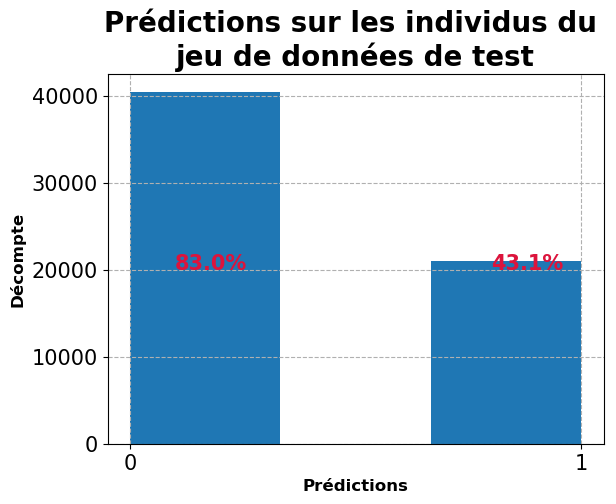

In [405]:
#Distribution des prédictions du modèle

class_0_ratio = pd.DataFrame({'A':test_predicted_class}).value_counts()[0]/len(production)
class_1_ratio = pd.DataFrame({'A':test_predicted_class}).value_counts()[1]/len(production)

plt.title("Prédictions sur les individus du \njeu de données de test", weight = 'bold', size = 20)
plt.rcParams.update({'font.size' : 15})
h = plt.hist(test_predicted_class, bins = 3)
plt.xlabel("Prédictions", size = 12, weight = 'bold')
plt.ylabel("Décompte", size = 12, weight = 'bold')
plt.grid(True, ls = '--')
tick = plt.xticks([0,1])
plt.text(0.1, 20000, "{}%".format(str(class_0_ratio*100)[:4]), color = 'crimson', weight = 'bold')
plt.text(0.8, 20000, "{}%".format(str(class_1_ratio*100)[:4]), color = 'crimson', weight = 'bold')

# 4- Analyse de Data Drift

In [406]:
#Importation de la librairie evidently

from evidently.report import Report
from evidently.metric_preset import DataDriftPreset
from evidently.metrics import *
from evidently.tests import *

In [407]:
#Génération du rapport de data drift sur l'ensemble des colonnes et enregistrement du tableau html

report = Report(metrics=[DataDriftPreset(),])
report.run(reference_data=train, current_data=production)
report.save_html('data_drift/drift_report.html')

In [409]:
#Récupération du tableau au format json, sauvegarde, ouverture et suppression
import json

report.save_json('drift_report.json')
with open('drift_report.json', 'r') as f:
    drift = json.loads(f.read())['metrics'][1]['result']['drift_by_columns']
os.remove('drift_report.json')

In [410]:
#Création d'un dictionnaire avec les seuls colonnes avec du data_drift détécté

final_dict = {"column_name" : [], "column_type" : [], "stattest_name" : [], "drift_score" : [], "threshold" : []}
for i in drift.keys():
    if drift[i]['drift_detected'] == True:
        final_dict["column_name"].append(drift[i]["column_name"])
        final_dict["column_type"].append(drift[i]["column_type"])
        final_dict["stattest_name"].append(drift[i]["stattest_name"])
        final_dict["drift_score"].append(drift[i]["drift_score"])
        final_dict["threshold"].append(drift[i]["threshold"])

In [411]:
#Affichage des informations sur les colonnes avec du DataDrift

final_dict

{'column_name': ['AMT_CREDIT',
  'DAYS_LAST_PHONE_CHANGE',
  'INSTAL_AMT_PAYMENT_SUM',
  'INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE',
  'PAYMENT_RATE',
  'PREV_NAME_CONTRACT_STATUS_Approved_MEAN',
  'PREV_NAME_PAYMENT_TYPE_Cash through the bank_MEAN',
  'PREV_NAME_YIELD_GROUP_high_MEAN',
  'NAME_CONTRACT_TYPE_Cash loans',
  'NAME_CONTRACT_TYPE_Revolving loans'],
 'column_type': ['num',
  'num',
  'num',
  'num',
  'num',
  'num',
  'num',
  'num',
  'cat',
  'cat'],
 'stattest_name': ['Wasserstein distance (normed)',
  'Wasserstein distance (normed)',
  'Wasserstein distance (normed)',
  'Wasserstein distance (normed)',
  'Wasserstein distance (normed)',
  'Wasserstein distance (normed)',
  'Wasserstein distance (normed)',
  'Wasserstein distance (normed)',
  'Jensen-Shannon distance',
  'Jensen-Shannon distance'],
 'drift_score': [0.20733907693482306,
  0.138975709303709,
  0.10677021190103245,
  0.1163042330311235,
  0.5747505097736826,
  0.1254904320286593,
  0.10566120074582158,
  0.10

In [415]:
#Mise sous la forme d'un dataframe

drift_df = pd.DataFrame(final_dict).sort_values(by = 'drift_score', ascending = False).reset_index().drop(['index'], axis = 1)
drift_df

,column_name,column_type,stattest_name,drift_score,threshold
0,PAYMENT_RATE,num,Wasserstein distance (normed),0.574751,0.1
1,AMT_CREDIT,num,Wasserstein distance (normed),0.207339,0.1
2,NAME_CONTRACT_TYPE_Cash loans,cat,Jensen-Shannon distance,0.147537,0.1
3,NAME_CONTRACT_TYPE_Revolving loans,cat,Jensen-Shannon distance,0.147537,0.1
4,DAYS_LAST_PHONE_CHANGE,num,Wasserstein distance (normed),0.138976,0.1
5,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,num,Wasserstein distance (normed),0.125490,0.1
6,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,num,Wasserstein distance (normed),0.116304,0.1
7,INSTAL_AMT_PAYMENT_SUM,num,Wasserstein distance (normed),0.106770,0.1
8,PREV_NAME_PAYMENT_TYPE_Cash through the bank_MEAN,num,Wasserstein distance (normed),0.105661,0.1
9,PREV_NAME_YIELD_GROUP_high_MEAN,num,Wasserstein distance (normed),0.100524,0.1


*NB: Le data drift est ici détécté avec un seuil de 0.1, ce qui peut être modifié via la librairie evidently. Un seuil amélioré peu fournir une meilleure visibilité sur le data drift.*

In [422]:
#Affichage des features importance

model_features_importance = pd.DataFrame(model[-1].feature_importances_, index = X_train.columns, columns = ['importance']).sort_values(by = 'importance', ascending = False)
model_features_importance['importance_rank'] = range(len(X_train.columns))
model_features_importance['column_name'] = model_features_importance.index
model_features_importance

,importance,importance_rank,column_name
PAYMENT_RATE,369,0,PAYMENT_RATE
PREV_NAME_SELLER_INDUSTRY_Furniture_MEAN,161,1,PREV_NAME_SELLER_INDUSTRY_Furniture_MEAN
NAME_TYPE_SUITE_Unaccompanied,136,2,NAME_TYPE_SUITE_Unaccompanied
OCCUPATION_TYPE_Laborers,119,3,OCCUPATION_TYPE_Laborers
PREV_APP_CREDIT_PERC_MIN,112,4,PREV_APP_CREDIT_PERC_MIN
...,...,...,...
PREV_NAME_PAYMENT_TYPE_Non-cash from your account_MEAN,0,187,PREV_NAME_PAYMENT_TYPE_Non-cash from your acco...
PREV_NAME_GOODS_CATEGORY_Auto Accessories_MEAN,0,188,PREV_NAME_GOODS_CATEGORY_Auto Accessories_MEAN
PREV_NAME_CONTRACT_STATUS_Unused offer_MEAN,0,189,PREV_NAME_CONTRACT_STATUS_Unused offer_MEAN
PREV_CHANNEL_TYPE_Stone_MEAN,0,190,PREV_CHANNEL_TYPE_Stone_MEAN


In [425]:
#Jointure avec le data frame de drift

merged_drift = drift_df.merge(model_features_importance).sort_values(by = 'importance', ascending = False)
merged_drift

,column_name,column_type,stattest_name,drift_score,threshold,importance,importance_rank
0,PAYMENT_RATE,num,Wasserstein distance (normed),0.574751,0.1,369,0
6,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,num,Wasserstein distance (normed),0.116304,0.1,26,36
9,PREV_NAME_YIELD_GROUP_high_MEAN,num,Wasserstein distance (normed),0.100524,0.1,17,42
3,NAME_CONTRACT_TYPE_Revolving loans,cat,Jensen-Shannon distance,0.147537,0.1,12,50
7,INSTAL_AMT_PAYMENT_SUM,num,Wasserstein distance (normed),0.106770,0.1,12,49
8,PREV_NAME_PAYMENT_TYPE_Cash through the bank_MEAN,num,Wasserstein distance (normed),0.105661,0.1,8,56
1,AMT_CREDIT,num,Wasserstein distance (normed),0.207339,0.1,2,74
2,NAME_CONTRACT_TYPE_Cash loans,cat,Jensen-Shannon distance,0.147537,0.1,0,184
4,DAYS_LAST_PHONE_CHANGE,num,Wasserstein distance (normed),0.138976,0.1,0,125
5,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,num,Wasserstein distance (normed),0.125490,0.1,0,165


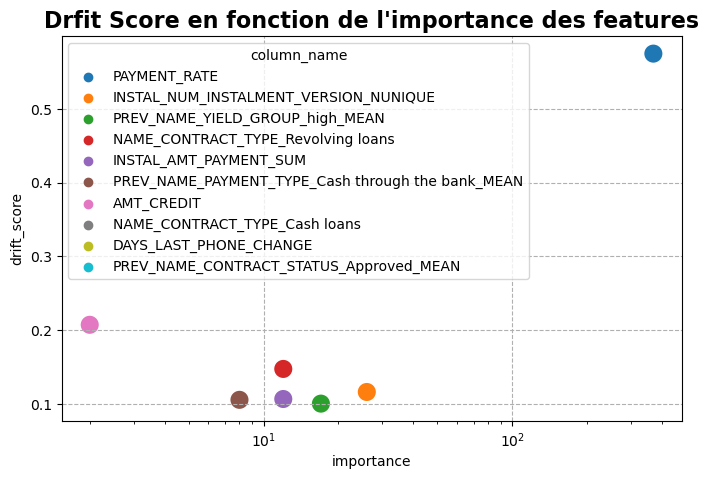

In [446]:
#Visualisation du data drift en fonction des features importances

plt.rcParams.update({'font.size' : 10})
plt.figure(figsize = (8,5))
plt.title("Drfit Score en fonction de l'importance des features", size = 16, weight = 'bold')
sns.scatterplot(data = merged_drift, x = 'importance', y = 'drift_score', hue = 'column_name', s = 200)
plt.grid(True, ls = '--')
plt.xscale('log')